<a href="https://colab.research.google.com/github/scumulder/Machine-Learning-Spring-2019-UCF/blob/master/Homework%203/3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2

Working with the **Cats vs Dogs** data set and the pretrained convnet VGG19:

*  Do fine-tuning with data augmentation


**Download the Data:**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 19:10:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  59.1MB/s    in 1.1s    

2019-04-18 19:10:46 (59.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

** Build network with VGG19 convolution base and custom densely connected layers:**

In [4]:
from keras.applications import VGG19

base_model = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
#base_model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 9s 0us/step


**Add the dense layers:**

In [5]:
from keras import layers
from keras import models
from keras import optimizers

network = models.Sequential()
network.add(base_model)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


**Augment the Data:**

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Fine-tune the data:**

In [0]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

**Compile and train the network:**

In [8]:
# Compile the network

network.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# Train the network

history = network.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 24s 241ms/step - loss: 0.5550 - acc: 0.7025 - val_loss: 0.3842 - val_acc: 0.8200
Epoch 2/20
100/100 [==============================] - 19s 188ms/step - loss: 0.3922 - acc: 0.8250 - val_loss: 0.2873 - val_acc: 0.8820
Epoch 3/20
100/100 [==============================] - 19s 189ms/step - loss: 0.3204 - acc: 0.8745 - val_loss: 0.3077 - val_acc: 0.8830
Epoch 4/20
100/100 [==============================] - 20s 195ms/step - loss: 0.2811 - acc: 0.8875 - val_loss: 0.2263 - val_acc: 0.9080
Epoch 5/20
100/100 [==============================] - 19s 192ms/step - loss: 0.2678 - acc: 0.8860 - val_loss: 0.2115 - val_acc: 0.9090
Epoch 6/20
100/100 [==============================] - 19s 189ms/step - loss: 0.2450 - acc: 0.8965 - val_loss: 0.2009 - val_acc: 0.9190
Epoch 7/20
100/100 [==============================] - 20s 200ms/step - loss: 0.2269 - acc: 0.9075 - val_loss: 0.2019 - val_acc: 0.9160
Epoch 8

**Display curves of loss and accuracy during training:**

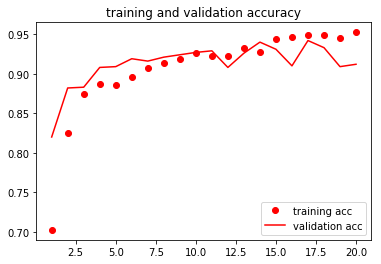

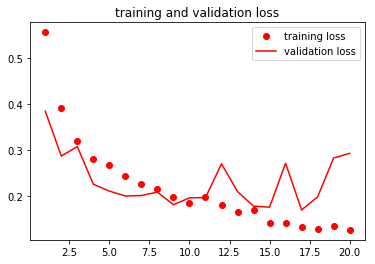

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'ro', label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'ro', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Evalutate the network using the validation data:**

In [10]:
val_loss, val_acc = network.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", round(val_acc*100,2), "%")

Validation loss: 0.2764855594560504
Validation accuracy: 90.9 %


**Save the model:**

To be used in Problem 4

In [0]:
model_fname = 'hw3p2.h5' 
network.save(model_fname)

# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)